---
title: "E-commerce Business Report"
subtitle: "A practice example of a pyspark business report"
author: "Dennis Feyerabend"
date: today                    # or "2025-01-15" or last-modified
date-format: long              # short, medium, long, full, or custom
abstract: "The project analyzes the e-commerce data of a fictitious company to identify insights and key trends. The report is written in Quarto and uses a custom theme (Arrakis Night). The primary purpose of the report was to practice pyspark and business reporting."

# Table of Contents
toc: true                        # Enable table of contents
toc-depth: 4                     # How many heading levels to include (1-6)
toc-title: "Contents"            # Custom TOC title
number-sections: true            # Add numbers to headings
number-depth: 4                  # How deep to number

# Code Display (Global Defaults)
execute:
  echo: true                     # Show code in output
  eval: true                     # Run the code
  warning: false                 # Hide warnings
  error: false                   # Stop on errors (true = continue)
  output: true                   # Show output


format:
  html:
    theme: ../themes/quarto_arrakis-night.scss
    embed-resources: true # Embed resources in HTML
    toc: true
    toc-location: right
    code-fold: true # Hide code blocks by default
---

# E-Commerce Business Report

In [1]:
#| echo: false
#| output: false

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum as spark_sum, avg as spark_avg, count, round as spark_round, max, min,
    desc, row_number, dense_rank,
    year, month, dayofweek, date_format,
    when, lit
)
from pyspark.sql.window import Window
import time

import matplotlib.pyplot as plt

# Apply> Arrakis Night to all plots
from themes import plot_arrakis_night_style
plot_arrakis_night_style.apply()


✓ Arrakis Night 'Rivers in the Desert' theme applied
  → Title: Peach | Labels: Gold | Ticks: Gray | Data: Water blues/greens


In [2]:
#| echo: false
#| output: false

print("=" * 60)
print("   Data Setup")
print("=" * 60)

spark = SparkSession.builder \
    .appName("E-Commerce Business Report") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"\nSpark Version: {spark.version}")
print("SparkSession bereit!")

# Steup path to data
DATA_PATH = "../data/ecommerce_5m.csv"

   Data Setup

Spark Version: 4.0.1
SparkSession bereit!


## Data overview:
The data for this report was created with the script `generate_bigdata.py`
and stored in the `data` folder.
The dataset used is `ecommerce_5m.csv`, containing **5 million rows**.

---

### Column Overview

| Column           | Description                         | Values / Range                                                                                                                                     |
|------------------|-------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| `transaction_id` | Unique identifier for each transaction | –                                                                                                                                                  |
| `customer_id`    | Unique identifier for each customer   | –                                                                                                                                                  |
| `date`           | Transaction date                     | 2023-01-01 → 2024-12-30                                                                                                                            |
| `product_category` | Product type                       | Beauty, Books, Electronics, Fashion, Food, Home & Garden, Sports, Toys                                                                            |
| `product_price`  | Product price in EUR                 | ≥ 0                                                                                                                                                |
| `quantity`       | Quantity of products per transaction | ≥ 1                                                                                                                                                |
| `payment_method` | Payment method                       | Apple Pay, Bank Transfer, Cash on Delivery, Credit Card, Klarna, PayPal                                                                           |
| `country`        | Country of purchase                  | Austria, Belgium, Denmark, Finland, France, Germany, Ireland, Netherlands, Poland, Spain, Switzerland                                             |
| `customer_age`   | Customer age                         | 18–74 years                                                                                                                                        |
| `total`          | Total transaction amount in EUR      | ≥ 0

In [3]:
#| echo: false
#| output: false

print("=" * 60)
print("     Visualize Data")
print("=" * 60)

# Load data
start = time.time()
df = spark.read.csv(
    DATA_PATH, header=True, inferSchema=True
)
load_time = time.time() - start
print(f"\nLoading time: {load_time:.2f} seconds")
print(f"Number of rows: {df.count():,}")

# Column overview
print(f"Number of columns: {len(df.columns)}")
print("\nOverview data schema:")
df.printSchema()

# Show age range
age_df = df.select(
    min("customer_age").alias("min_age"),
    max("customer_age").alias("max_age")
).collect()[0]
print(f"\nAge range: {age_df['min_age']} - {age_df['max_age']} years")

# Show date range
date_df = df.select(
    min("date").alias("min_date"),
    max("date").alias("max_date")
).collect()[0]
print(f"\nDate range: {date_df['min_date']} to {date_df['max_date']}")

# Show unique country values
print("\nUnique country values:")
country_overview = df.select("country").distinct().orderBy("country")
country_overview.show(truncate=False)

# Show unique categorical values
print("\nUnique product_category values:")
product_overview = df.select("product_category").distinct().orderBy("product_category")
product_overview.show(truncate=False)

# Show unique payment_method values
print("\nUnique payment_method values:")
payment_overview = df.select("payment_method").distinct().orderBy("payment_method")
payment_overview.show(truncate=False)


# Data overview
print(f"\nData overview with first 15 rows:")
temp_table = df.toPandas().head(15)
temp_table.style.hide(axis="index") # Remove index

     Visualize Data

Loading time: 3.55 seconds
Number of rows: 5,000,000
Number of columns: 10

Overview data schema:
root
 |-- transaction_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- product_category: string (nullable = true)
 |-- product_price: double (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- country: string (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- total: double (nullable = true)


Age range: 18 - 74 years

Date range: 2023-01-01 to 2024-12-30

Unique country values:
+-----------+
|country    |
+-----------+
|Austria    |
|Belgium    |
|France     |
|Germany    |
|Netherlands|
|Poland     |
|Switzerland|
+-----------+


Unique product_category values:
+----------------+
|product_category|
+----------------+
|Beauty          |
|Books           |
|Electronics     |
|Fashion         |
|Food            |
|Home & Garden   |
|S

transaction_id,customer_id,date,product_category,product_price,quantity,payment_method,country,customer_age,total
1,476496,2023-04-13,Home & Garden,327.880000,2,Apple Pay,Austria,57,655.760000
2,456606,2024-03-11,Sports,334.490000,1,Bank Transfer,Switzerland,26,334.490000
3,146952,2023-09-28,Home & Garden,403.160000,1,Klarna,Poland,23,403.160000
4,394072,2023-04-17,Electronics,479.530000,5,PayPal,Austria,19,2397.650000
5,61010,2023-03-13,Toys,83.570000,5,Credit Card,Germany,31,417.850000
6,120875,2024-12-01,Books,31.970000,1,Klarna,Austria,64,31.970000
7,337021,2023-01-21,Food,45.200000,3,Bank Transfer,Germany,37,135.600000
8,474553,2024-09-06,Fashion,13.570000,2,Credit Card,France,70,27.140000
9,441512,2023-05-02,Beauty,109.960000,3,Credit Card,Austria,42,329.880000
10,312465,2024-04-11,Home & Garden,204.720000,1,Klarna,Netherlands,64,204.720000


## Goals of analyses

The report aims to answer the following questions:

1. Which country is most important for business?
2. Which products generate the most revenue?
3. Which customers are most important and how are they characterized?

# Revenue per country

### Insights: Country revenue contribution over the last two years:
- Germany is the clear core market, contributing 45% of total revenue over the last two years. This high concentration makes Germany the primary driver of overall business performance.
- Austria (15%), Switzerland (12%), and the Netherlands (10%) form a stable second tier, accounting for ~37% combined. These markets provide meaningful diversification and reduce dependence on Germany.
- Belgium, France, and Poland together contribute less than 15%, representing smaller but steady markets with limited impact on overall revenue trends.
- The geographic revenue distribution is highly stable, suggesting a mature market structure with no major shifts in regional demand.

In [4]:
#| echo: false

country_df = df.groupBy("country") \
    .agg(
        count("*").alias("order_volume"),
        spark_round(spark_sum("total")/1000000, 2).alias("total_revenue_mill"),
        spark_round(spark_avg("total"), 2).alias("avg_revenue")
    )

window_all = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

country_df = country_df.withColumn("revenue_percent", spark_round(col("total_revenue_mill")/spark_sum("total_revenue_mill").over(window_all)*100, 2))

country_df = country_df.orderBy(desc("total_revenue_mill"))

table_df = (
    country_df.toPandas()
        .style.hide(axis="index")
        .format({
            "total_revenue_mill": "{:,.2f}",
            "avg_revenue": "{:,.2f}",
            "revenue_percent": "{:,.2f}"
        })
        .set_properties(
            subset=["total_revenue_mill", "avg_revenue", "revenue_percent"],
            **{"text-align": "right"}
        )
        .set_table_styles([
            {"selector": "td",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]},
            {"selector": "th",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]}
        ])
)

# Display df
table_df

country,order_volume,total_revenue_mill,avg_revenue,revenue_percent
Germany,2250568,"1,287.82",572.22,45.04
Austria,750533,428.72,571.21,14.99
Switzerland,599950,343.80,573.05,12.02
Netherlands,499471,285.42,571.44,9.98
Belgium,399549,228.03,570.71,7.98
France,300321,171.71,571.76,6.01
Poland,199608,113.76,569.93,3.98


### Insights: Yearly country revenue:

- There are no noticable changes in revenue contribution between countries for the years 2023 and 2024.

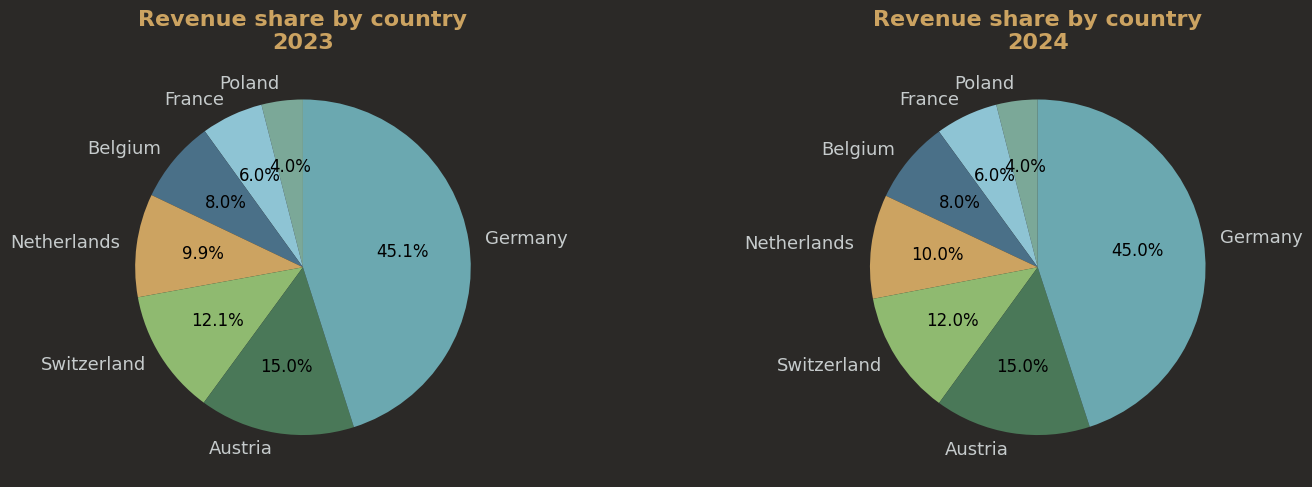

In [5]:
#| echo: false

yearly_country_df = df.withColumn("year", year(col("date"))) \
    .groupBy("year", "country") \
    .agg(
        count("*").alias("order_volume"),
        spark_round(spark_sum("total")/1000000, 2).alias("total_revenue_mill"),
        spark_round(spark_avg("total"), 2).alias("avg_revenue")
    )

# Create monthly window
w_year = Window.partitionBy("year")
yearly_country_df = yearly_country_df.withColumn(
    "revenue_yearly_percent",
    spark_round(col("total_revenue_mill") / spark_sum("total_revenue_mill").over(w_year) * 100, 2)
).orderBy("year", "revenue_yearly_percent")

# Filter DF two generate one df for each year
year_one_df = yearly_country_df.filter(col("year") == 2023)
year_two_df = yearly_country_df.filter(col("year") == 2024)

# Convert Spark → Pandas
pdf_1 = year_one_df.toPandas()
pdf_2 = year_two_df.toPandas()

# two plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Capture the returned values
wedges_1, texts_1, autotexts_1 = axes[0].pie(
    pdf_1["revenue_yearly_percent"],
    labels=pdf_1["country"],
    autopct="%1.1f%%",
    startangle=90
)

axes[0].set_title("Revenue share by country\n2023", fontsize=16)
axes[0].tick_params(labelsize=14)

# Adjust text sizes
for t in texts_1:
    t.set_fontsize(13)

for t in autotexts_1:
    t.set_color("black")
    t.set_fontsize(12)

wedges_2, texts_2, autotexts_2 = axes[1].pie(
pdf_2["revenue_yearly_percent"],
labels=pdf_2["country"],
autopct="%1.1f%%",
startangle=90
)

axes[1].set_title("Revenue share by country\n2024", fontsize=16)
axes[1].tick_params(labelsize=14)

# Adjust text sizes
for t in texts_2:
    t.set_fontsize(13)

for t in autotexts_2:
    t.set_color("black")
    t.set_fontsize(12)

plt.tight_layout()
plt.show()

In [6]:
#| echo: false
#| output: false

# Create DF with monthly revenue for 2024
month_country_df = (df.filter(year(col("date")) == 2024)
                    .withColumn("month", month(col("date")))
                    .withColumn("month_name", date_format(col("date"), "MMMM"))
                    .groupBy("month", "month_name", "country") \
    .agg(
        count("*").alias("order_volume"),
        spark_round(spark_sum("total")/1000000, 2).alias("total_revenue_mill"),
        spark_round(spark_avg("total"), 2).alias("avg_revenue")
    ) \
    .orderBy("month", "country"))

# Create monthly window
w_month = Window.partitionBy("month")
month_country_df = month_country_df.withColumn(
    "revenue_monthly_percent",
    spark_round(col("total_revenue_mill") / spark_sum("total_revenue_mill").over(w_month) * 100, 2)
)

### Insights: Monthly country revenue for 2024:
- Revenue contribution between countries has been stable over the last year.

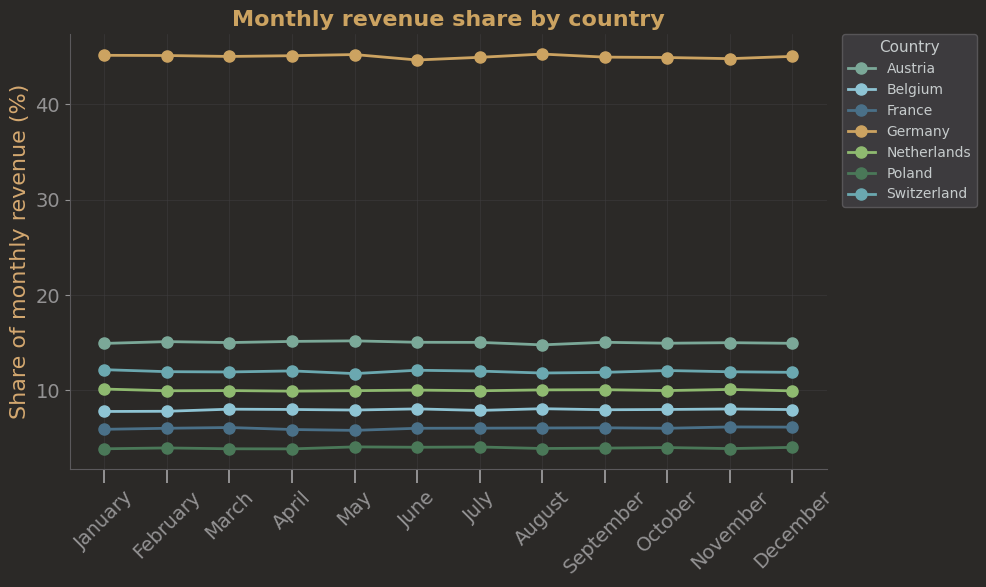

In [7]:
#| echo: false

pdf = month_country_df.toPandas()

# Months labels
months_labels = pdf["month_name"].unique().tolist()

# Create pivot for lineplot
pivot = pdf.pivot(
    index="month",
    columns="country",
    values="revenue_monthly_percent"
).sort_index()

# Plot Line chart
fig, ax = plt.subplots(figsize=(10, 6))

for cat in pivot.columns:
    ax.plot(pivot.index, pivot[cat], marker="o", label=cat)

ax.set_xticks(pivot.index)
ax.set_xticklabels(months_labels, rotation=45)
ax.tick_params(axis="x", direction="out", length=10, width=1.4, labelsize=14)
ax.tick_params(axis="y", labelsize=14)

ax.set_title("Monthly revenue share by country", fontsize=16)
ax.set_ylabel("Share of monthly revenue (%)", fontsize=16)
ax.set_xlabel("")
ax.legend(
    title="Country",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.show()

### Key insight:
- The company revenue is heavily dependent on the German market. Diversification is needed.

# Revenue per Product Category

### Insights: Product revenue contribution
- Electronics dominate total revenue generation (53.5%) but expose the business to concentration risk. Any sector downturn in electronics would heavily impact total revenue.
- Lower-performing categories represent only ~7% of revenue. These categories could be candidates for portfolio optimization, consolidation, or targeted growth strategies

In [8]:
#| echo: false

product_df = df.groupBy("product_category") \
    .agg(
        count("*").alias("order_volume"),
        spark_round(spark_sum("total")/1000000, 2).alias("total_revenue_mill"),
        spark_round(spark_avg("total"), 2).alias("avg_revenue")
    )

window_all = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

product_df = product_df.withColumn("revenue_percent", spark_round(col("total_revenue_mill")/spark_sum("total_revenue_mill").over(window_all)*100, 2))

product_df = product_df.orderBy(desc("total_revenue_mill"))

table_df = (
    product_df.toPandas()
        .style.hide(axis="index")
        .format({
            "total_revenue_mill": "{:,.2f}",
            "avg_revenue": "{:,.2f}",
            "revenue_percent": "{:,.2f}"
        })
        .set_properties(
            subset=["total_revenue_mill", "avg_revenue", "revenue_percent"],
            **{"text-align": "right"}
        )
        .set_table_styles([
            {"selector": "td",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]},
            {"selector": "th",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]}
        ])
)

# Display df
table_df

product_category,order_volume,total_revenue_mill,avg_revenue,revenue_percent
Electronics,1248965,"1,530.18","1,225.16",53.52
Home & Garden,750846,459.77,612.33,16.08
Fashion,999124,367.59,367.91,12.86
Sports,600309,299.19,498.39,10.46
Toys,300645,74.84,248.94,2.62
Beauty,400233,73.56,183.80,2.57
Books,499513,34.38,68.83,1.20
Food,200365,19.74,98.54,0.69


### Insights: Product revenue contribution over the last two years (2023 + 2024):

- There are no noticable changes revenue contribution between products between the years 2023 and 2024.

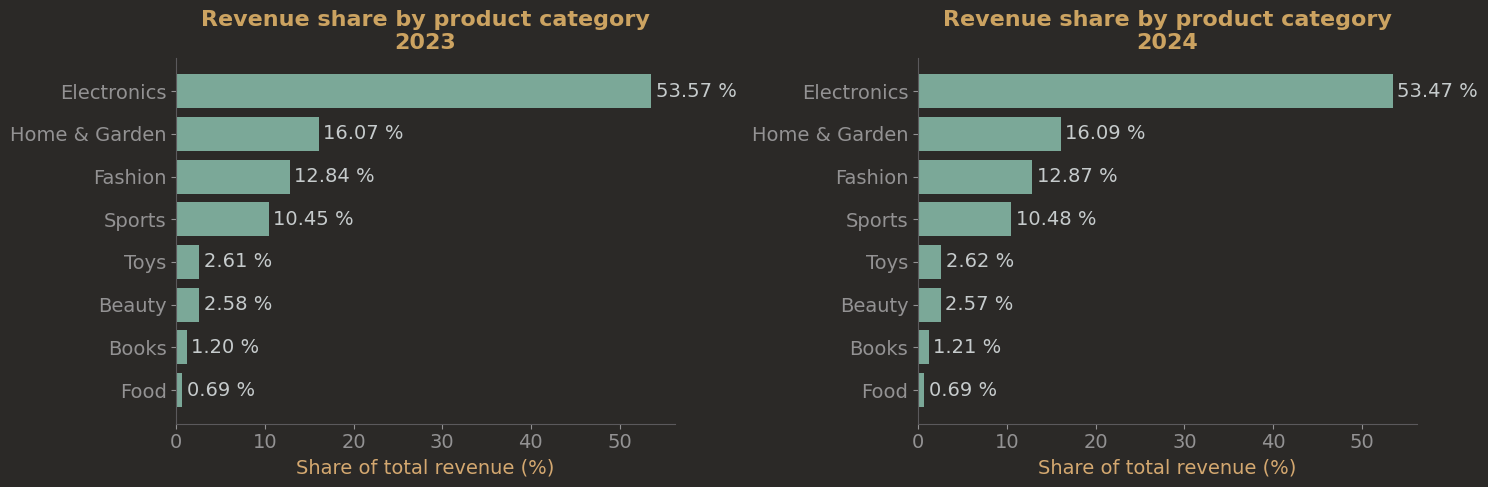

In [9]:
#| echo: false
import numpy as np

yearly_product_df = df.withColumn("year", year(col("date"))) \
    .groupBy("year", "product_category") \
    .agg(
        count("*").alias("order_volume"),
        spark_round(spark_sum("total")/1000000, 2).alias("total_revenue_mill"),
        spark_round(spark_avg("total"), 2).alias("avg_revenue")
    )

# Create monthly window
w_year = Window.partitionBy("year")
yearly_product_df = yearly_product_df.withColumn(
    "revenue_yearly_percent",
    spark_round(col("total_revenue_mill") / spark_sum("total_revenue_mill").over(w_year) * 100, 2)
).orderBy("year", "revenue_yearly_percent")

# Filter DF two generate one df for each year
year_one_df = yearly_product_df.filter(col("year") == 2023)
year_two_df = yearly_product_df.filter(col("year") == 2024)

# Convert Spark → Pandas
pdf_1 = year_one_df.toPandas().sort_values("revenue_yearly_percent", ascending=False)
pdf_2 = year_two_df.toPandas().sort_values("revenue_yearly_percent", ascending=False)

# Create two bar charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Bars: % share of total revenue
axes[0].barh(
    pdf_1["product_category"],
    pdf_1["revenue_yearly_percent"]
)
axes[0].set_title("Revenue share by product category\n2023", fontsize=16)
axes[0].set_xlabel("Share of total revenue (%)", fontsize=14)
axes[0].set_ylabel("")
axes[0].tick_params(labelsize=14)
axes[0].invert_yaxis()
axes[0].grid(False)

# Add % labels to the right of each bar
for i, pct in enumerate(pdf_1["revenue_yearly_percent"]):
    axes[0].text(
        pct + 0.5,                 # x-position
        i,                         # y-position
        f"{pct:.2f} %",
        va="center",
        ha="left",
        fontsize=14
    )

axes[1].barh(
    pdf_2["product_category"],
    pdf_2["revenue_yearly_percent"]
)
axes[1].set_title("Revenue share by product category\n2024", fontsize=16)
axes[1].set_xlabel("Share of total revenue (%)", fontsize=14)
axes[1].set_ylabel("")
axes[1].tick_params(labelsize=14)
axes[1].invert_yaxis()
axes[1].grid(False)

# Add % labels to the right of each bar
for i, pct in enumerate(pdf_2["revenue_yearly_percent"]):
    axes[1].text(
        pct + 0.5,                 # x-position
        i,                         # y-position
        f"{pct:.2f} %",
        va="center",
        ha="left",
        fontsize=14
    )

plt.tight_layout()
plt.show()

### Monthly product revenue contribution for 2024:

- Product category revenue shares are highly stable throughout the year, indicating predictable customer demand and low volatility across categories.

In [10]:
#| echo: false
#| output: false

# Create DF with monthly revenue for 2024
month_product_df = (df.filter(year(col("date")) == 2024)
                    .withColumn("month", month(col("date")))
                    .withColumn("month_name", date_format(col("date"), "MMMM"))
                    .groupBy("month", "month_name", "product_category") \
    .agg(
        count("*").alias("order_volume"),
        spark_round(spark_sum("total")/1000000, 2).alias("total_revenue_mill"),
        spark_round(spark_avg("total"), 2).alias("avg_revenue")
    ) \
    .orderBy("month", "product_category"))

# Create monthly window
w_month = Window.partitionBy("month")
month_product_df = month_product_df.withColumn(
    "revenue_monthly_percent",
    spark_round(col("total_revenue_mill") / spark_sum("total_revenue_mill").over(w_month) * 100, 2)
)

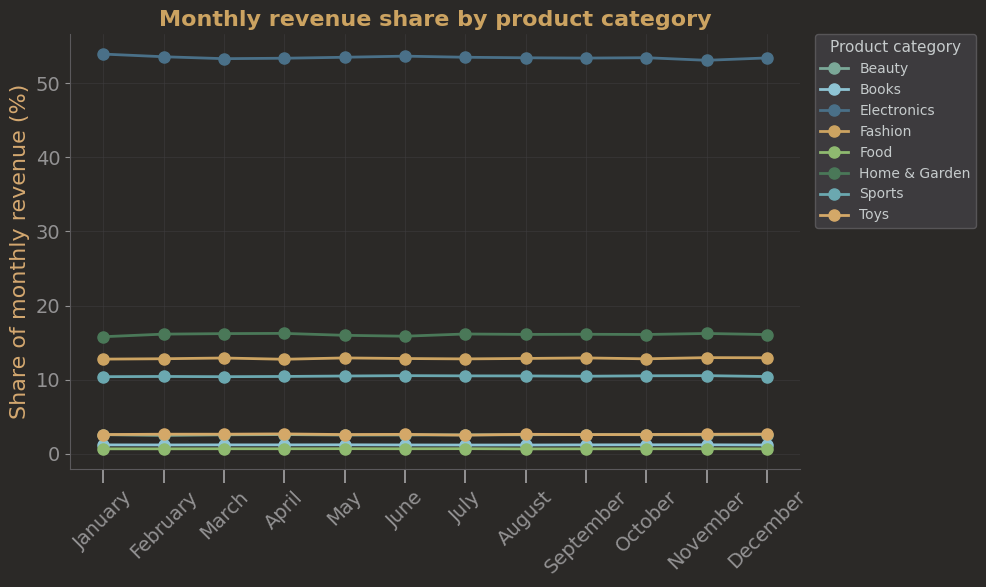

In [11]:
#| echo: false

pdf = month_product_df.toPandas()

# Months labels
months_labels = pdf["month_name"].unique().tolist()

# Create pivot for lineplot
pivot = pdf.pivot(
    index="month",
    columns="product_category",
    values="revenue_monthly_percent"
).sort_index()

# Plot Line chart
fig, ax = plt.subplots(figsize=(10, 6))

for cat in pivot.columns:
    ax.plot(pivot.index, pivot[cat], marker="o", label=cat)

ax.set_xticks(pivot.index)
ax.set_xticklabels(months_labels, rotation=45)
ax.tick_params(axis="x", direction="out", length=10, width=1.4, labelsize=14)
ax.tick_params(axis="y", labelsize=14)

ax.set_title("Monthly revenue share by product category", fontsize=16)
ax.set_ylabel("Share of monthly revenue (%)", fontsize=16)
ax.set_xlabel("")
ax.legend(
    title="Product category",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.show()

### Key insight:
- The company revenue is heavily dependent on Electronics. Diversification is recommended.

# Top products per country

### Insights: Top revenue generating products per country:
- The top products are the same between countries
- The most profitable products are Electronics, followed by Home & Garden articles and then Fasion

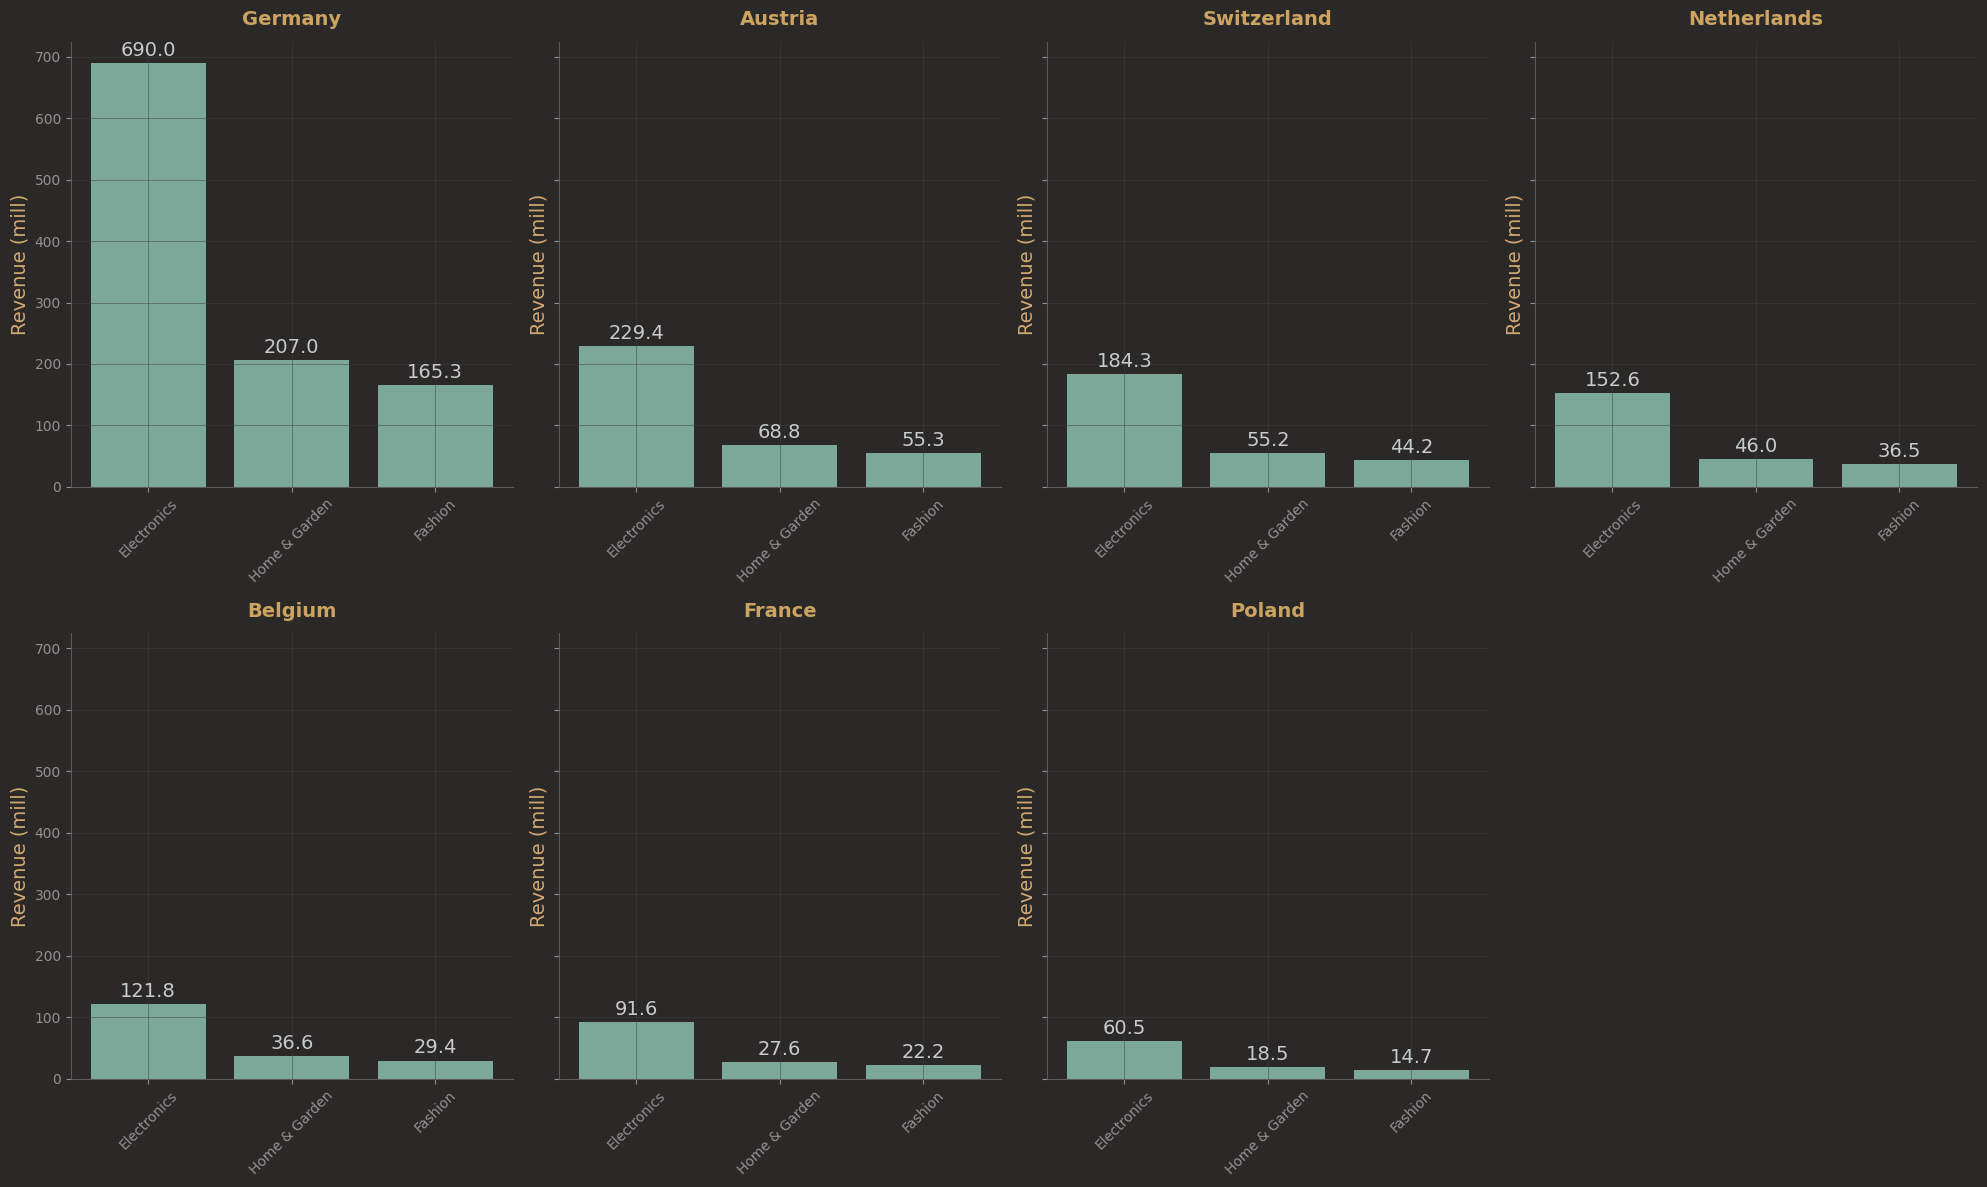

In [12]:
#| echo: false

country_category = df.groupBy("country", "product_category") \
    .agg(
        count("*").alias("order_volume"),
        spark_round(spark_sum("total")/1000000, 2).alias("total_revenue_mill"),
        spark_round(spark_avg("total"), 2).alias("avg_revenue")
    )

#Define window
window = Window.partitionBy("country").orderBy(desc("total_revenue_mill"))

# Rank highest rev product for each country
ranking = country_category.withColumn("rank", row_number().over(window))

ranking = ranking.filter(col("rank") <= 3).orderBy("country", "rank")

# Convert Spark → Pandas
pdf = ranking.toPandas()

# Take ordered country names from country_df
countries = country_df.toPandas()["country"].tolist()
n = len(countries)

# 4 columns → calculate rows automatically
cols = 4
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(
    nrows=rows,
    ncols=cols,
    figsize=(5 * cols, 6 * rows),   # ← THIS makes charts readable
    sharey=True
)

axes = axes.flatten()   # flatten 2D array

for ax, country in zip(axes, countries):
    sub = pdf[pdf["country"] == country].sort_values("rank")

    ax.bar(
        sub["product_category"],
        sub["total_revenue_mill"]
    )

    ax.set_title(country, fontsize=14, pad=12)
    ax.set_xlabel("", fontsize=14)
    ax.set_ylabel("Revenue (mill)", fontsize=14)
    ax.tick_params(axis="x", rotation=45)

    # Value labels
    for i, val in enumerate(sub["total_revenue_mill"]):
        ax.text(i, val + 5, f"{val:.1f}", ha="center", va="bottom", fontsize=14)

# Hide unused empty subplots if any
for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Customer analysis

### Insights: Top customers:

- Revenue contribution increases almost linearly across the entire customer base, indicating a steady relationship between customer count and revenue generated.
- Revenue is broadly distributed rather than concentrated among a small set of high-value customers. No single customer group disproportionately drives total revenue.
- No distinct “VIP customer” segment emerges. Instead, a larger upper segment of customers collectively represents the most valuable group, contributing meaningfully without extreme outliers.

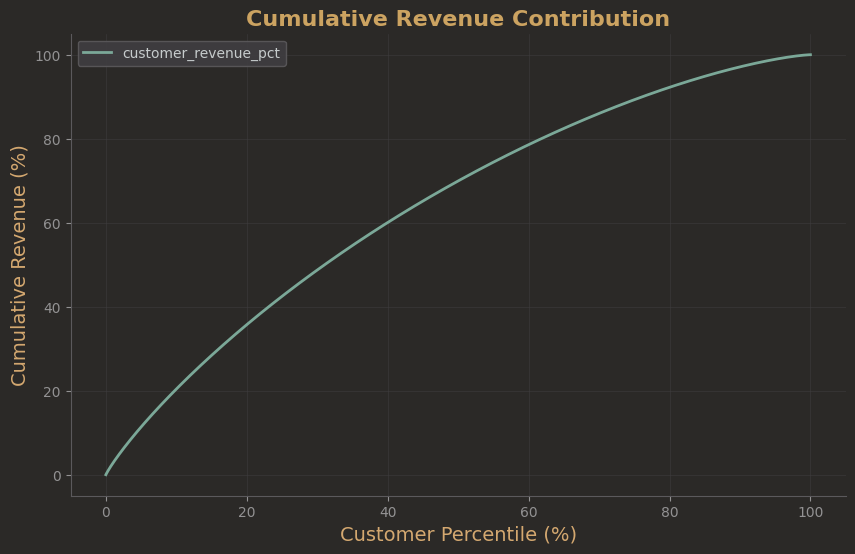

In [22]:
#| echo: false

customer_df = df.groupBy("customer_id") \
    .agg(
        count("*").alias("order_volume"),
        spark_round(spark_sum("total"), 2).alias("total_revenue"),
        spark_round(spark_avg("total"), 2).alias("avg_revenue")
    ) \
    .orderBy("total_revenue", ascending=False)

pdf = customer_df.orderBy("total_revenue", ascending=False).toPandas()

pdf["customer_revenue"] = pdf["total_revenue"].cumsum()
pdf["customer_revenue_pct"] = pdf["customer_revenue"] / pdf["total_revenue"].sum() * 100
pdf["customer_pct"] = (pdf.index + 1) / len(pdf) * 100

pdf.plot.line(
    x="customer_pct",
    y="customer_revenue_pct"
)

plt.xlabel("Customer Percentile (%)", fontsize=14)
plt.ylabel("Cumulative Revenue (%)", fontsize=14)
plt.title("Cumulative Revenue Contribution", fontsize=16);

# Summary of Results


## Key Insights

- Revenue is concentrated in a small set of countries with Germany being the most important (followed by Austria, Switzerland and Netherlands).
- A few product categories account for the majority of total sales.
- Category and country contributions remain stable over time, indicating predictable customer demand.
- The same products consistently appear as top revenue drivers within each country.
- There is no distinct small group of "VP customers", instead the majority of customers contribute meaningfully to total revenue.


## Recommendations

- Strengthen marketing and promotional strategies in the top-performing countries.
- Evaluate opportunities to expand in mid-tier markets with growing potential.
- Prioritize inventory planning for high-impact product categories and top-selling items.